# Introduction


Many cities in the US are in debt; in 2021, San Diego had a debt burden of \$2.1
billion, and Sacramento's was \$607.5 million according to [Truth In
Accounting's (TIA) 2021
report](https://www.truthinaccounting.org/news/detail/financial-state-of-the-cities-2021).
Year over year cities like San Diego sink deeper into debt---there
isn't enough tax revenue to turn the situation around.

While unpaid retirement benefits may be the largest single driver of debt,
there are many other smaller services that the city offers which come with
their own liabilities, and when combined make up a significant portion of the
overall debt.  Some of these municipal services may include sewage, other
utilities, public safety, and roads/highways.  In one case, the [city of Remer, MN was
forced to look to grants and loans to replace 300ft of leaking
pipe](https://www.strongtowns.org/journal/2019/7/1/my-journey-from-free-market-ideologue-to-strong-towns-advocate),
which it wouldn't otherwise be able to afford, thus creating more debt.

Many of these infrastructure-related services share a common trait: their scale
is influenced by urban design, especially urban sprawl.  My goal with these
Value-per-acre analyses is to better understand which existing development
patterns are more or less financially solvent for a city by plotting the tax
value per lot area of taxable parcels in different neighborhoods for
comparison.


# References

* Strong Towns Member Leads a DIY Value Per Acre Analysis - <https://www.strongtowns.org/journal/2019/10/11/strong-towns-member-leads-a-diy-value-per-acre-analysis> ([archive link](https://web.archive.org/web/20211127151939/https://www.strongtowns.org/journal/2019/10/11/strong-towns-member-leads-a-diy-value-per-acre-analysis))
* Value Per Acre Analysis forum post, Strong Town San Diego forum - <https://forum.strongtownsandiego.org/viewtopic.php?f=2&t=628> ([archive link](https://web.archive.org/web/20200808212412/https://forum.strongtownsandiego.org/viewtopic.php?f=2&t=628))


In [198]:
# Extract all relevant GIS archives downloaded from the SanGIS/SANDAG GIS Data
# Warehouse (San Diego's Regional GIS Data Source)

import zipfile
import os

SHAPEFILES = {
    "parcels": {
        "downloaded_archive": "san_diego_data/downloads/Parcels.zip",
    },
    "municipal_boundaries": {
        "downloaded_archive": "san_diego_data/downloads/Municipal_Boundaries.zip",
    },
    "council_districts": {
        "downloaded_archive": "san_diego_data/downloads/Council_Districts.zip",
    },
    "zoning": {
        "downloaded_archive": "san_diego_data/downloads/ZONING_BASE_SD.zip",
    },
    "landuse": {
        "downloaded_archive": "san_diego_data/downloads/LANDUSE_CURRENT.zip",
    },
}

# All the extracted data files will be created underneath.
SHAPEFILES_ROOT_DIR = "san_diego_data/shapefiles"

# This is a custom polygon representing the pacific ocean just off the southern california coast
# which I adapted from Shoreline Mapping Program CA1101A data, found at: https://www.ngs.noaa.gov/NSDE/
OCEAN_SHAPEFILE = "san_diego_data/shoreline/pacific_ocean_SD.shp"

# Extract all the shapefile archives specified by SHAPEFILES above.
for dataset_name, dataset_paths in SHAPEFILES.items():
    with zipfile.ZipFile(dataset_paths["downloaded_archive"], "r") as zip_ref:
        outputs_path = os.path.join(SHAPEFILES_ROOT_DIR, dataset_name)
        if "shapefile_name" in dataset_paths.keys():
            shapefile_path = os.path.join(outputs_path, dataset_paths["shapefile_name"])
        else:
            # Find the first .shp file and use it.
            shapefile_archive_member = [m for m in zip_ref.namelist() if m.lower().endswith('.shp')][0]
            shapefile_path = os.path.join(outputs_path, shapefile_archive_member)
        # update the SHAPEFILES dictionary to help downstream code find the shapefile.
        dataset_paths["shapefile"] = shapefile_path
        # Finally, extract the zip archives, but only if we haven't already.
        if not os.path.exists(shapefile_path):
            shapedata = zip_ref.extractall(path=outputs_path)

In [193]:
# For each municipality, generate and save shapefiles containing all taxable parcels in each municipality.
# This cell can take tens of minutes or hours to calculate depending on your computer.

import os
import geopandas as gpd

FORCE_RECALCULATE = False

# Load and cleanup the municipal boundaries.
municipal_boundaries = gpd.read_file(SHAPEFILES['municipal_boundaries']['shapefile']).to_crs(epsg=4326)
# remove the encapsulating county boundary.
municipal_boundaries = municipal_boundaries[municipal_boundaries["CODE"] != "CN"]
# remove the duplicate entries by selecting only the most up-to-date versions
municipal_boundaries["METERS_AREA"] = municipal_boundaries["geometry"].to_crs(epsg=3395).area
municipal_boundaries = (
    municipal_boundaries
    .groupby(["CODE"])
    .apply(lambda x: x.sort_values(by=['METERS_AREA']).tail(1))
)

municipal_configs = {
    code: {
        "views": {
            "default": {}
        }
    }
    for code in municipal_boundaries["CODE"]
}

# Configure overrides for each municipality.
municipal_configs["SD"]["views"]["default"] = {
    "xlim": (-117.30, -116.98),
    "ylim": (32.66, 33.07),
}
municipal_configs["CV"]["views"]["west"] = {
    "xlim": (-117.1040, -117.0360),
    "ylim": (32.5869, 32.6603),
}
municipal_configs["CV"]["views"]["denser_suburb"] = {
    "xlim": (-117.0490, -117.0410),
    "ylim": (32.613817, 32.621018),
}
municipal_configs["IB"]["views"]["default"] = {
    "xlim": (-117.1372, -117.0994),
    "ylim": (32.5632, 32.5914),
}
municipal_configs["NC"]["views"]["default"] = {
    "xlim": (-117.1285, -117.0492),
    "ylim": (32.6468, 32.6932),
}

for municipal_code, municipal_config in municipal_configs.items():
    municipal_name = municipal_boundaries[municipal_boundaries["CODE"] == municipal_code]["NAME"].str.title()[0]
    municipal_config["parcels_cache_path"] = f"working_layers/parcels_clipped_{municipal_code}.shp"

    if os.path.exists(municipal_config["parcels_cache_path"]) and not FORCE_RECALCULATE:
        print(f"Skip recalculating cache layer for minicipality {municipal_code} ({municipal_name}).")
    else:
        print(f"Recalculating parcels layer for minicipality {municipal_code} ({municipal_name})...")
        parcels = gpd.read_file(SHAPEFILES['parcels']['shapefile']).to_crs(epsg=4326)

        # Limit parcels to the ones which claim to be in the current municipality, according to the
        # jurisdiction field.
        parcels = parcels[parcels["SITUS_JURI"] == municipal_code]

        # There are still a few leftover anomalous parcels way outside the municipal boundary, so
        # further scope down the parcels by using the municipal boundary as a clipping mask.
        municipal_boundary = municipal_boundaries[municipal_boundaries["CODE"] == municipal_code]["geometry"]
        parcels = gpd.clip(parcels, municipal_boundary, keep_geom_type=True)

        # Finally, save the parcels
        print(f"Saving parcels layer for municipality {municipal_code} ({municipal_name})...")
        parcels.to_file(municipal_config["parcels_cache_path"])

        print(f"Saved parcels layer for municipality {municipal_code} ({municipal_name}).")

Skip recalculating cache layer for minicipality CB (Carlsbad).
Skip recalculating cache layer for minicipality CO (Coronado).
Skip recalculating cache layer for minicipality CV (Chula Vista).
Skip recalculating cache layer for minicipality DM (Del Mar).
Skip recalculating cache layer for minicipality EC (El Cajon).
Skip recalculating cache layer for minicipality EN (Encinitas).
Skip recalculating cache layer for minicipality ES (Escondido).
Skip recalculating cache layer for minicipality IB (Imperial Beach).
Skip recalculating cache layer for minicipality LG (Lemon Grove).
Skip recalculating cache layer for minicipality LM (La Mesa).
Skip recalculating cache layer for minicipality NC (National City).
Skip recalculating cache layer for minicipality OC (Oceanside).
Skip recalculating cache layer for minicipality PW (Poway).
Skip recalculating cache layer for minicipality SD (San Diego).
Skip recalculating cache layer for minicipality SM (San Marcos).
Skip recalculating cache layer for mi

In [160]:
# Prepare some generally helpful landuse features that can be useful for better context about the area.  These
# essentially serve as a "baselayer".

import geopandas as gpd

# Pull in the landuse dataset so that we can draw local features.  Land use codes are defined here:
# https://www.sandag.org/resources/maps_and_gis/gis_downloads/downloads/codes/land_use_codes.html
landuse = gpd.read_file(SHAPEFILES['landuse']['shapefile']).to_crs(epsg=4326)
roads = landuse[landuse["lu"].isin((
    4112, # Freeway
    4118, # Road Right of Way
))]
water = landuse[landuse["lu"].isin((
    9202, # Lake/Reservoir/Large Pond
    9201, # Bay or Lagoon
))]["geometry"].append(
    gpd.read_file(OCEAN_SHAPEFILE).to_crs(epsg=4326)["geometry"]
)

In [194]:
# This cell contains most of the shared mapping code.  It's reponsible for looping over each view of
# each municipality, generating pretty titles, combining multiple layers into a plot and saving the outputs.

import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import Image, display
from mpl_toolkits.axes_grid1 import make_axes_locatable

def generate_maps(
    map_type_title=None, map_type_code=None, process_parcels=None, plot_column=None, get_vmax=None, get_vmin=None
):
    for municipal_code, municipal_config in municipal_configs.items():
        # Get a pretty version of the full municipality name.
        municipal_name = municipal_boundaries[municipal_boundaries["CODE"] == municipal_code]["NAME"].str.title()[0]

        parcels = None

        # Get the municipal boundary for the current municipality.
        municipal_boundary = municipal_boundaries[municipal_boundaries["CODE"] == municipal_code]["geometry"]

        for view_name, view_config in municipal_config["views"].items():
            filename_suffix = municipal_code if view_name == "default" else f"{municipal_code}_{view_name}"
            out_filename = f"renders/{map_type_code}_{filename_suffix}.jpg"

            if os.path.exists(out_filename):
                print(f"Skipping view {out_filename}")
            else:
                if parcels is None:
                    # Load parcels for the current municipality from the cache file.
                    parcels = gpd.read_file(municipal_config["parcels_cache_path"]).to_crs(epsg=4326)
                    # Process the parcels to add a field to plot.
                    parcels = process_parcels(parcels=parcels)
                    
                # Start to create plot.
                fig, ax = plt.subplots(figsize = (8.5,11))
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("right", size=0.3, pad=0.0)

                # Plot all the layers
                municipal_boundary.plot(ax=ax, facecolor=(.8, .8, .8, 1))
                roads.plot(ax=ax, color=(0.9, 0.9, 0.9))
                water.plot(ax=ax, color=(0.6, 0.7, 0.8))
                parcels.plot(
                    column=plot_column,
                    ax=ax,
                    cax=cax,
                    cmap="inferno",
                    vmin=get_vmin(parcels),
                    vmax=get_vmax(parcels),
                    legend=True
                )
                municipal_boundaries.plot(ax=ax, facecolor=(0, 0, 0, 0), edgecolor=(.5, .5, .5), linewidth=0.8)

                # Configure the rest of the figure parameters.
                municipal_subtitle = "" if view_name == "default" else f" ({view_name.title()})"
                ax.set_title(f"{municipal_name}{municipal_subtitle}: {map_type_title}", fontdict = {"fontsize": 17})
                if "xlim" in view_config:
                    # We have configured some custom limits for this municipality.
                    ax.set_xlim(*view_config["xlim"])
                    ax.set_ylim(*view_config["ylim"])
                else:
                    # Assume that we just want to use the extent of the municipal boundary as the plot limits.
                    ax.set_xlim([municipal_boundary.total_bounds[0],  municipal_boundary.total_bounds[2]])
                    ax.set_ylim([municipal_boundary.total_bounds[1],  municipal_boundary.total_bounds[3]])
                fig.set_dpi(300.0)
                ax.axes.get_xaxis().set_ticks([])
                ax.axes.get_yaxis().set_ticks([])
                ax.annotate(
                    "Source: SanGIS, 2022",
                    xy=(10, 10),
                    xycoords="axes points",
                    horizontalalignment="left",
                    verticalalignment="bottom",
                    fontsize=10,
                    color=(0.2, 0.2, 0.2, 0.5),
                    backgroundcolor=(1, 1, 1, 0.7),
                )

                jpeg_args = {"optimize": True, "quality": 92}
                plt.savefig(out_filename, bbox_inches="tight", pil_kwargs=jpeg_args, dpi=300)
                print(f"Saved {out_filename}")
                plt.close()

            if municipal_code == "SD":
                display(Image(filename=out_filename))

        # Free memory to make room for next batch of parcels.
        del parcels

In [48]:
# In order to determine revenue-per-acre, one thing we need to determine is the property tax rate.
# However, the tax rate is not uniform across the whole county, but instead the county is
# geographically divided into thousands of little "tax rate areas" (TRA), each with slightly
# different tax rates.
#
# The goal of this cell is to extract the tax rate area (TRA) numbers from a PDF file titled "TAX
# RATE BY TAX RATE AREA FISCAL YEAR 2020-21" found at this URL:
# https://www.sandiegocounty.gov/content/dam/sdc/auditor/trb2021/tralist.pdf
# The product will be a mapping of TRA numbers to tax rates.

import os
import subprocess
import re
import pandas as pd
import numpy as np

DOWNLOADS_ROOT_DIR = "san_diego_data/downloads"
TRA_LIST_FILE = os.path.join(DOWNLOADS_ROOT_DIR, "tralist.pdf")

tra_list_rawtext = subprocess.run(["pdftotext", TRA_LIST_FILE, "-"], capture_output=True).stdout.decode("utf-8")
tra_list_raw_lines = tra_list_rawtext.splitlines()
tax_rates_data = []
while tra_list_raw_lines:
    if re.compile(r"[0-9]{5}").match(tra_list_raw_lines[0]) is not None:
        tax_rates_data.append([int(tra_list_raw_lines[0]), float(tra_list_raw_lines[2])])
        del tra_list_raw_lines[0:3]
    else:
        del tra_list_raw_lines[0]

tax_rates = pd.DataFrame(
    tax_rates_data,
    columns=["TRANUM", "TAX_RATE"],

)

tax_rates

TRANUM  TAX_RATE
0          1   1.78263
1       1051   1.14477
2       1074   1.14477
3       1104   1.14477
4       1131   1.14477
...      ...       ...
5129   96105   1.10481
5130   94179   1.05706
5131   96044   1.14081
5132   96081   1.10481
5133   96106   1.10481

[5134 rows x 2 columns]

Skipping view renders/revenue_per_acre_CB.jpg
Skipping view renders/revenue_per_acre_CO.jpg
Skipping view renders/revenue_per_acre_CV.jpg
Skipping view renders/revenue_per_acre_CV_west.jpg
Skipping view renders/revenue_per_acre_CV_denser_suburb.jpg
Skipping view renders/revenue_per_acre_DM.jpg
Skipping view renders/revenue_per_acre_EC.jpg
Skipping view renders/revenue_per_acre_EN.jpg
Skipping view renders/revenue_per_acre_ES.jpg
Skipping view renders/revenue_per_acre_IB.jpg
Skipping view renders/revenue_per_acre_LG.jpg
Skipping view renders/revenue_per_acre_LM.jpg
Skipping view renders/revenue_per_acre_NC.jpg
Skipping view renders/revenue_per_acre_OC.jpg
Skipping view renders/revenue_per_acre_PW.jpg
Skipping view renders/revenue_per_acre_SD.jpg


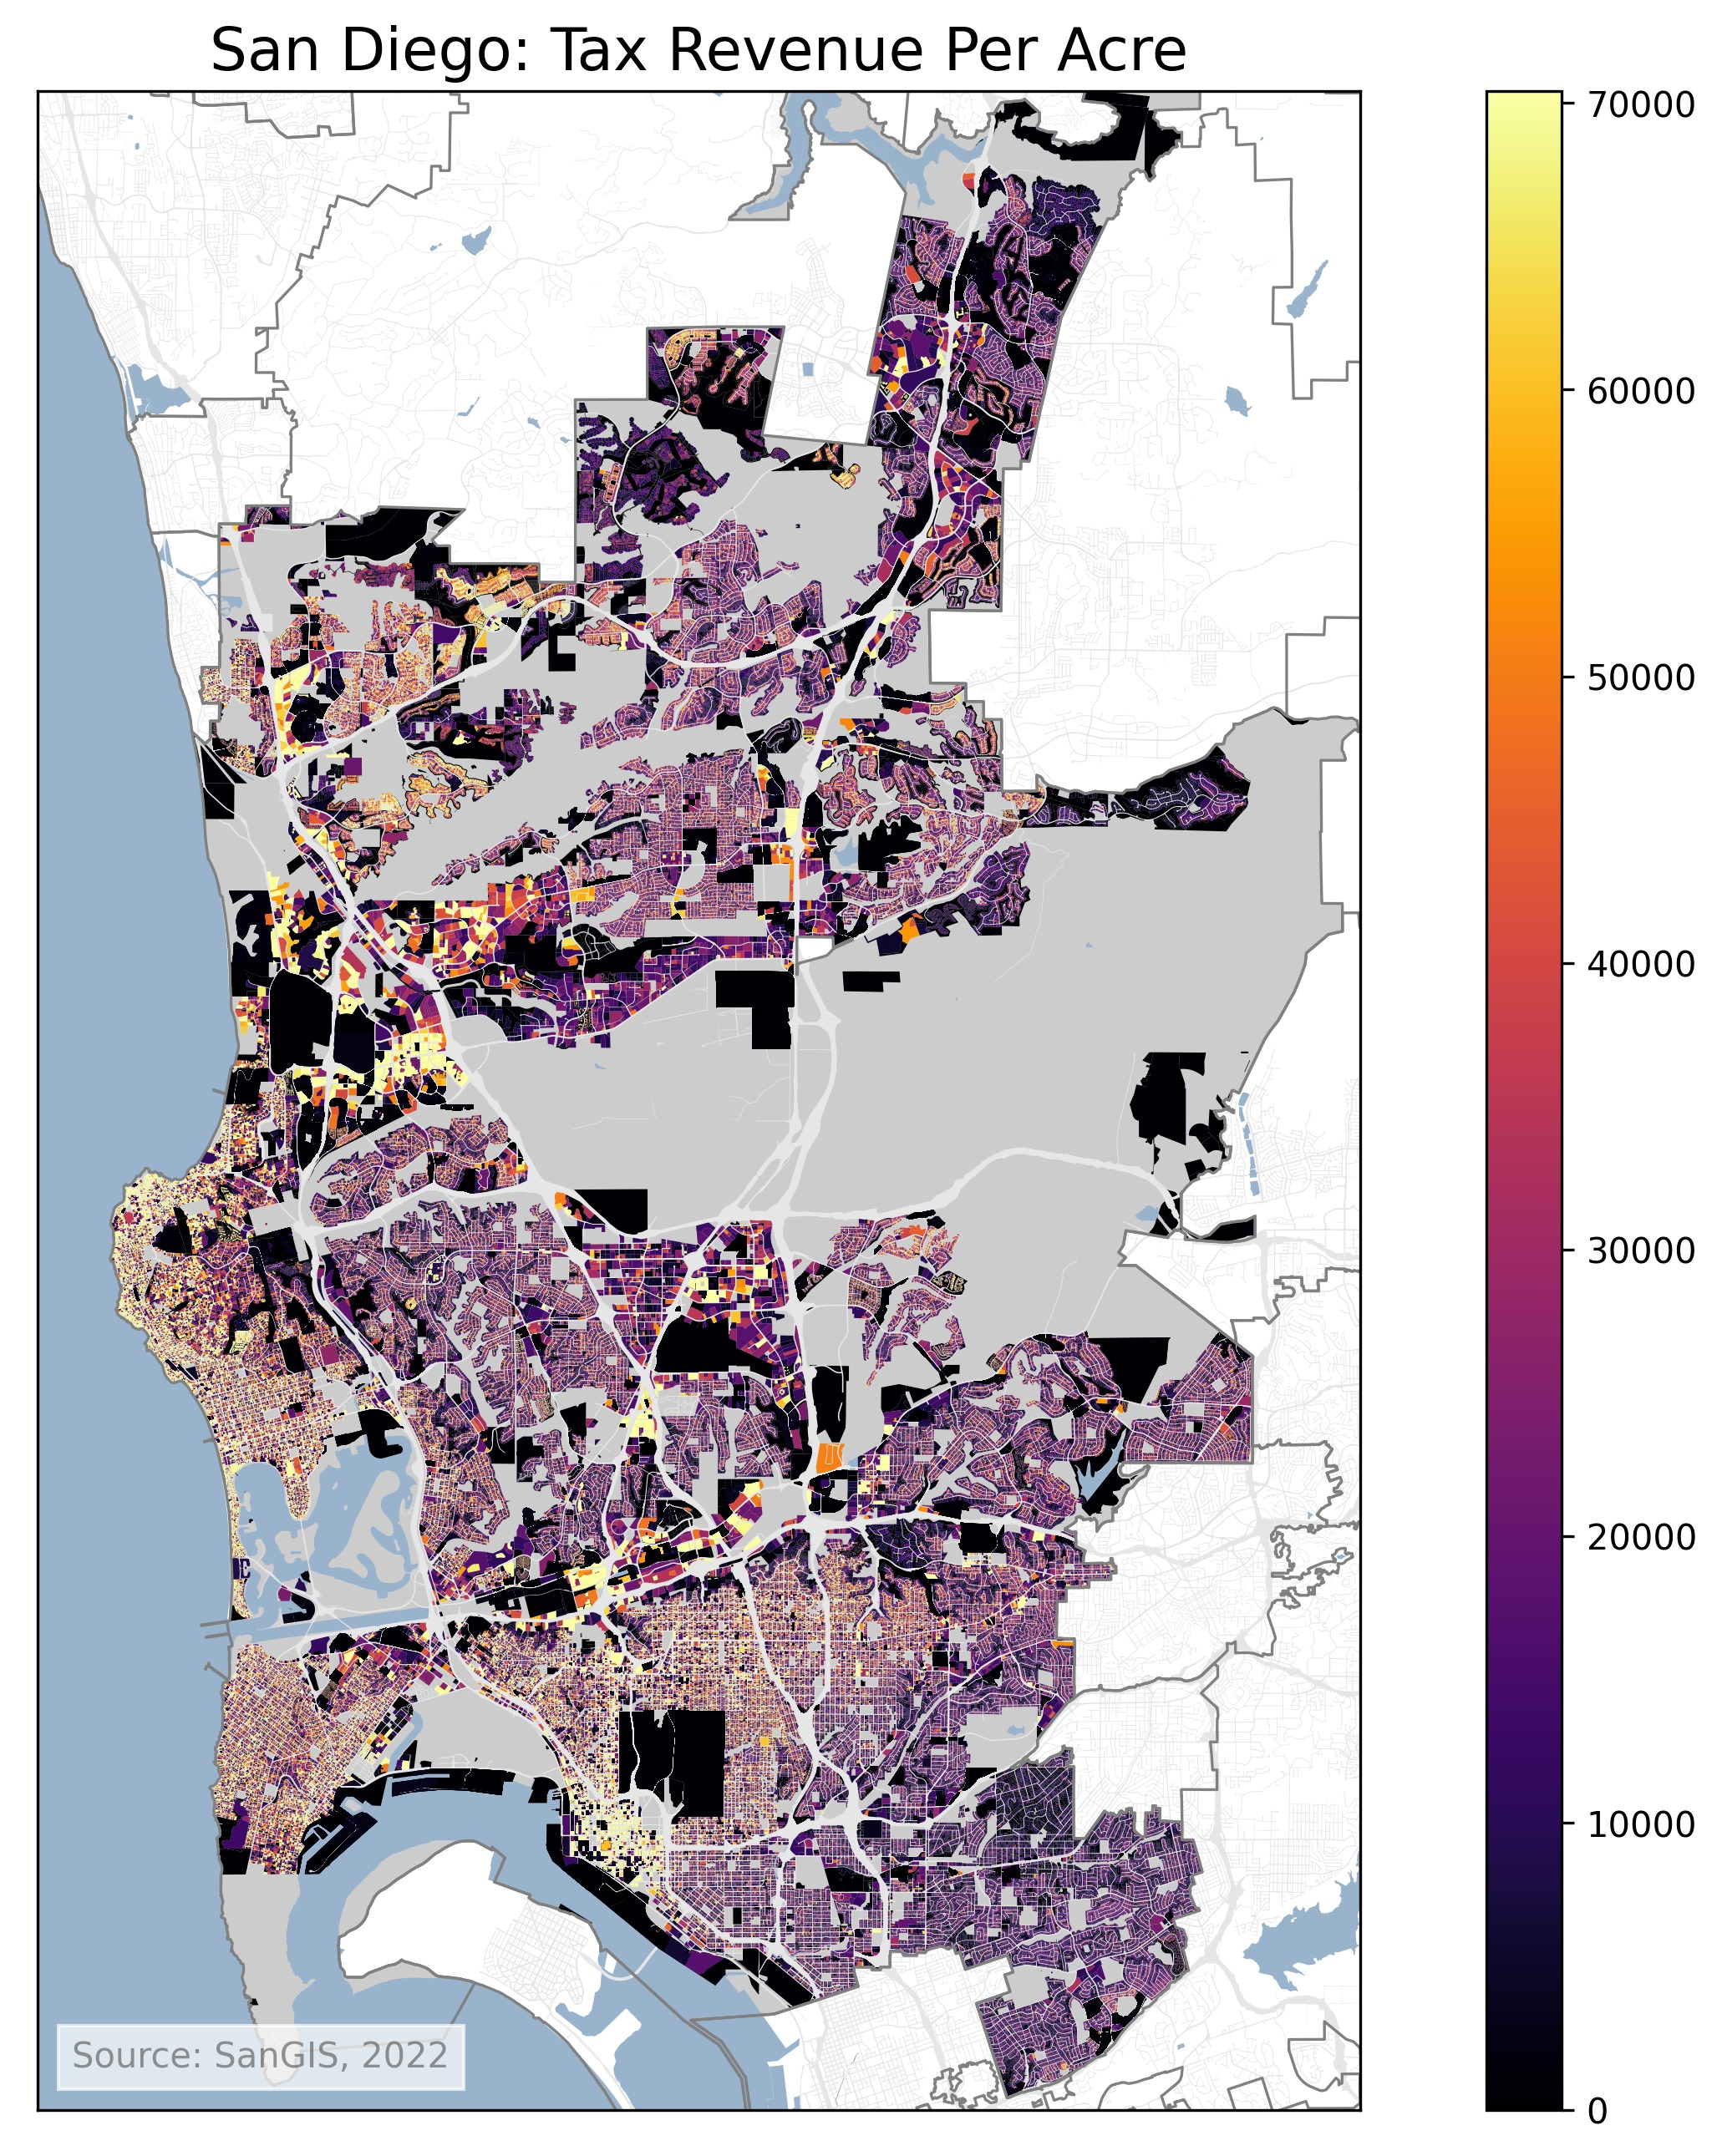

Skipping view renders/revenue_per_acre_SM.jpg
Skipping view renders/revenue_per_acre_SO.jpg
Skipping view renders/revenue_per_acre_ST.jpg
Skipping view renders/revenue_per_acre_VS.jpg


In [195]:
# Finally, generate Tax Revenue Per Acre plots for each municipality.  

def process_parcels_revenu_per_acre(parcels=None):
    # Join tax rates data so that we know what the tax rate is for each parcel.
    parcels["TRANUM"] = parcels["TRANUM"].astype(int)
    parcels = parcels.merge(tax_rates, on="TRANUM")

    # Only taxable parcels
    parcels = parcels[parcels["TAXSTAT"] == "T"]
    # Only parcels with valid tax rates and assessment values
    parcels = parcels.dropna(axis=0, subset=["TAX_RATE", "ASR_TOTAL"])
    # remove non-urban parcels according to the landuse (NUCLEUS_US)
    # Several types of "open space" parcels are still unfiltered because I need those later to estimate
    # area sharing of parcels belonging to HOAs.
    parcels["NUCLEUS_US"] = parcels["NUCLEUS_US"].astype(int)
    parcels = parcels[
        ~parcels["NUCLEUS_US"].isin([
            450,  # NATURAL RESOURCES-MINIG, EXTRACTIVE, PROCESS
            851,  # MILITARY BASE
            #862,  # OPEN SPACE OWNED BY A DEVELOPER 
            864,  # OPEN SPACE ESMT-IN FAVOR OF GOVERNMENT
        ])
    ]
    parcels = parcels[~((parcels["NUCLEUS_US"] >= 500) & (parcels["NUCLEUS_US"] < 600))]  # IRRIGATED FARM
    parcels = parcels[~((parcels["NUCLEUS_US"] >= 600) & (parcels["NUCLEUS_US"] < 700))]  # RURAL

    # remove non-urban parcels according to the zone (NUCLEUS_ZO)
    parcels["NUCLEUS_ZO"] = parcels["NUCLEUS_ZO"].astype(int)
    parcels = parcels[
        ~(parcels["NUCLEUS_ZO"].isin([
            80, # AGRICULTURAL
        ]))
    ]
    
    # First, re-project geometries to an equal-area projection (EPSG:3395) with units in meters.
    # Then, calculate the acres of each geometry, dividing by the magic number 4046.8564 to convert m^2 to acre.
    parcels["AREA_ACRES"] = parcels["geometry"].to_crs(epsg=3395).map(lambda g: g.area / 4046.8564)
    
    # Try to find all the HOAs, and distribute the shared area evenly amongst the private areas.
    parcels = parcels.fillna(value={"OWN_ADDR1": "", "OWN_NAME1": ""})
    hoa_parcel_groups = (
        parcels
        .groupby("SUBMAP")
        # filter down the sublots to just those which have traits of a homeowners association.
        .filter(lambda g:
                (len(g[g["ASR_TOTAL"] > 0]) > 0) &
                (
                    (len(g[g["OWN_NAME1"].str.contains("OWNERS ASSN")]) > 0) |
                    (len(g[g["OWN_NAME1"].str.contains("OWNERS ASSOC")]) > 0) |
                    (len(g[g["OWN_NAME1"].str.contains("COMMUNITY ASSOC")]) > 0) |
                    (len(g[g["OWN_NAME1"].str.endswith(" ASSN")]) > 0) |
                    (len(g[g["OWN_NAME1"].str.endswith(" ASSOC")]) > 0) |
                    (len(g[g["OWN_NAME1"].str.endswith(" ASSOCIA")]) > 0) |
                    (len(g[g["OWN_NAME1"].str.endswith(" HOMEOWNERS")]) > 0) |
                    
                    (len(g[g["OWN_ADDR1"].str.contains("OWNERS ASSN")]) > 0) |
                    (len(g[g["OWN_ADDR1"].str.contains("OWNERS ASSOC")]) > 0) |
                    (len(g[g["OWN_ADDR1"].str.contains("COMMUNITY ASSOC")]) > 0) |
                    (len(g[g["OWN_ADDR1"].str.endswith(" ASSN")]) > 0) |
                    (len(g[g["OWN_ADDR1"].str.endswith(" ASSOC")]) > 0) |
                    (len(g[g["OWN_ADDR1"].str.endswith(" ASSOCIA")]) > 0) |
                    (len(g[g["OWN_ADDR1"].str.endswith(" HOMEOWNERS")]) > 0)
                )
               )
        .groupby("SUBMAP")
    )
    def get_hoa_area(group):
        # Get the total area of an HOA that is shared between all tenants.
        area_acres_hoa_shared = group[group["ASR_TOTAL"] == 0]["AREA_ACRES"].sum()
        if area_acres_hoa_shared == 0:
            # Sometimes, the shared area is not assessed at zero, so this is just an approximation of
            # the shared area by treating the largest parcel in the group as the shared one.
            area_acres_hoa_shared = group["AREA_ACRES"].max()
        number_of_private_parcels = len(group[group["ASR_TOTAL"] > 0])
        return area_acres_hoa_shared / len(group[group["ASR_TOTAL"] > 0])
    if hoa_parcel_groups.ngroups > 0:
        parcels = parcels.merge(
            pd.DataFrame(hoa_parcel_groups.apply(get_hoa_area), columns=["AREA_ACRES_EXTRA"]),
            on="SUBMAP",
            how="left",
        )
        parcels = parcels.fillna(value={"AREA_ACRES_EXTRA":0})
    else:
        parcels["AREA_ACRES_EXTRA"] = 0
    
    # TAX_RATE was determined by the Tax Rate Area (TRA) of the parcel in a previous cell.  Value in percent.
    # ASR_TOTAL is defined as the "Total assessed value" of the property.  See Parcels.pdf for more details.
    parcels["TAX_REVENUE"] = parcels["TAX_RATE"] / 100 * parcels["ASR_TOTAL"]
    
    # Finally, calculate the metric we want to display in colors.
    parcels["TAX_REVENUE_PER_ACRE"] = parcels["TAX_REVENUE"] / (parcels["AREA_ACRES"] + parcels["AREA_ACRES_EXTRA"])
    
    return parcels

generate_maps(
    map_type_title="Tax Revenue Per Acre",
    map_type_code="revenue_per_acre",
    process_parcels=process_parcels_revenu_per_acre,
    plot_column="TAX_REVENUE_PER_ACRE",
    get_vmin=lambda p: 0,
    get_vmax=lambda p: p["TAX_REVENUE_PER_ACRE"].quantile(0.95)
)

Skipping view renders/document_update_year_CB.jpg
Skipping view renders/document_update_year_CO.jpg
Skipping view renders/document_update_year_CV.jpg
Skipping view renders/document_update_year_CV_west.jpg
Skipping view renders/document_update_year_CV_denser_suburb.jpg
Skipping view renders/document_update_year_DM.jpg
Skipping view renders/document_update_year_EC.jpg
Skipping view renders/document_update_year_EN.jpg
Skipping view renders/document_update_year_ES.jpg
Skipping view renders/document_update_year_IB.jpg
Skipping view renders/document_update_year_LG.jpg
Skipping view renders/document_update_year_LM.jpg
Skipping view renders/document_update_year_NC.jpg
Skipping view renders/document_update_year_OC.jpg
Skipping view renders/document_update_year_PW.jpg
Skipping view renders/document_update_year_SD.jpg


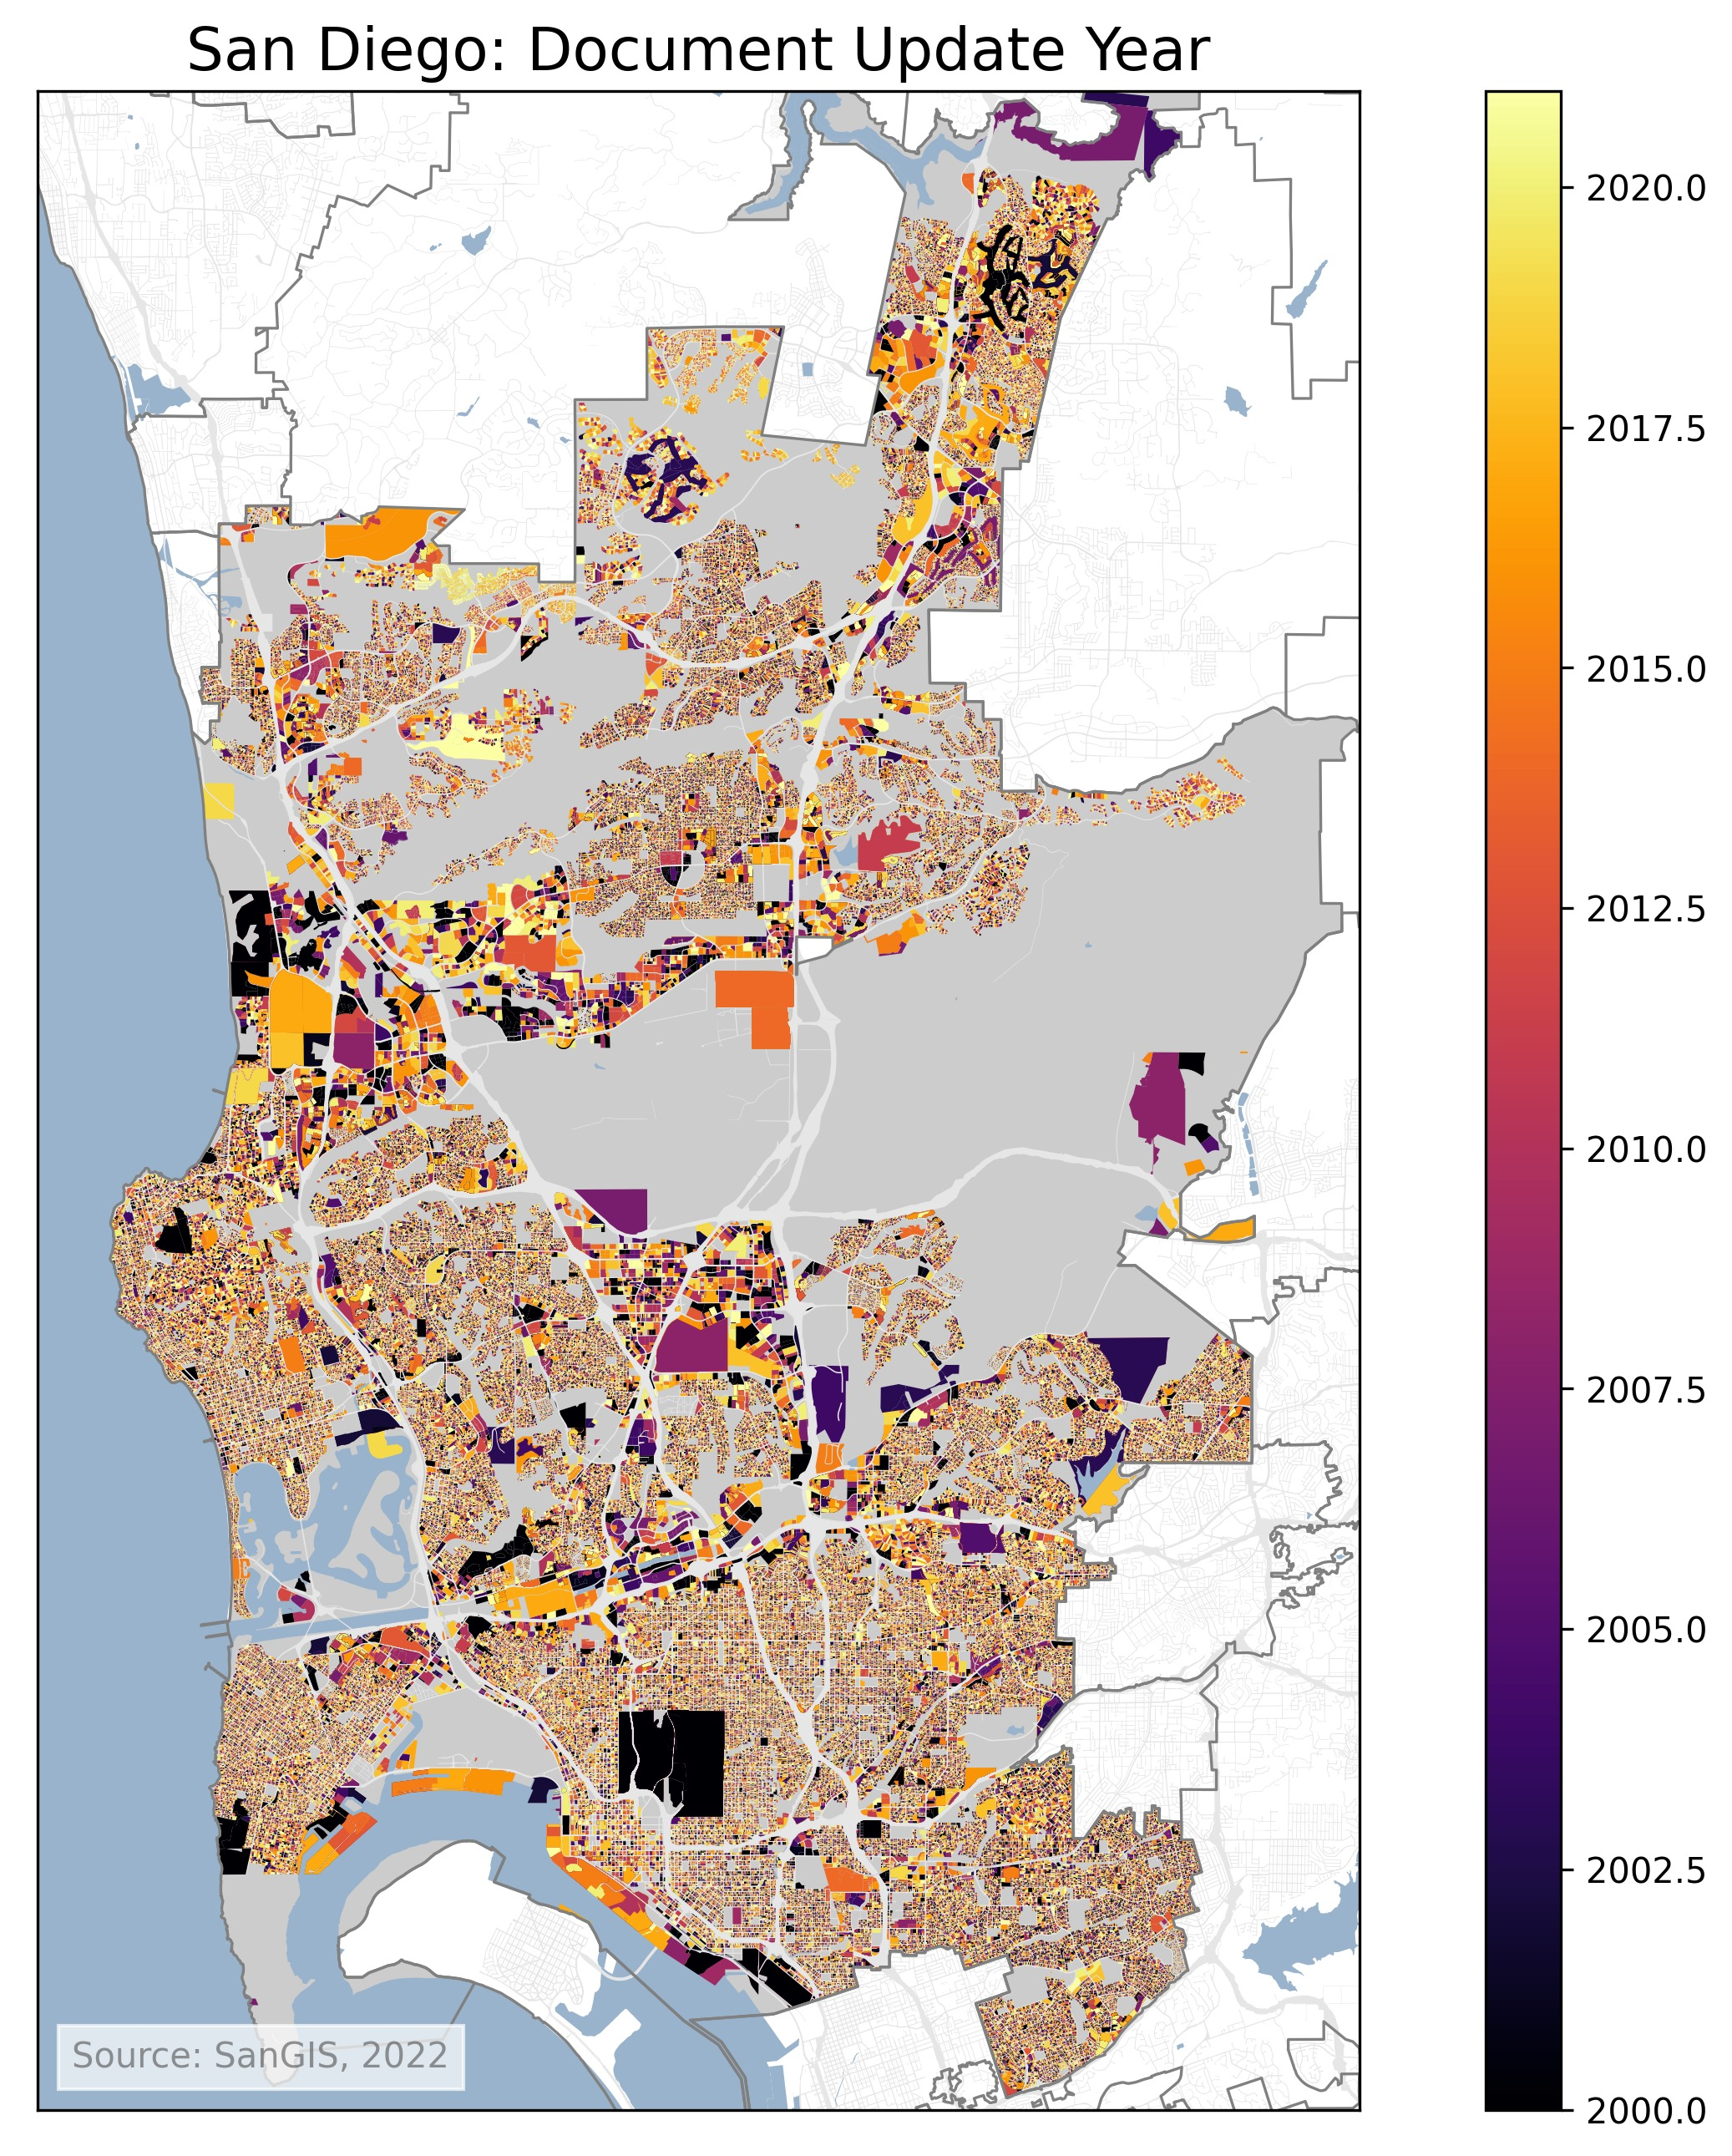

Skipping view renders/document_update_year_SM.jpg
Skipping view renders/document_update_year_SO.jpg
Skipping view renders/document_update_year_ST.jpg
Skipping view renders/document_update_year_VS.jpg


In [196]:
# Plot the DOCDATE (Document Update Year) field of every taxable urban parcel.
# I was skeptical that many of these parcels have been updated with the most recent value assessment because
# many parcels were unusually low valued, so I was hoping the DOCDATE field would shed some light on that.
# As it turns out, most parcels are up-to-date.  I later learned the real reason many properties have very low
# value assessments: California Proposition 13 <https://en.wikipedia.org/wiki/1978_California_Proposition_13>
# Prop 13 limits tax increases on properties except in the event of a change of ownership.

import numpy as np

def process_parcels_document_update_year(parcels=None):
    # Only taxable parcels
    parcels = parcels[parcels["TAXSTAT"] == "T"]
    # Only parcels with valid tax rates and assessment values
    parcels = parcels.dropna(axis=0, subset=["ASR_TOTAL"])
    parcels = parcels[parcels["ASR_TOTAL"] > 0]
    # remove non-urban parcels according to the landuse (NUCLEUS_US)
    parcels["NUCLEUS_US"] = parcels["NUCLEUS_US"].astype(int)
    parcels = parcels[
        ~parcels["NUCLEUS_US"].isin([
            450,  # NATURAL RESOURCES-MINIG, EXTRACTIVE, PROCESS
            851,  # MILITARY BASE
            860,  # OPEN SPACE
            861,  # OPEN SPACE OWNED BY AN HOA
            862,  # OPEN SPACE OWNED BY A DEVELOPER 
            864,  # OPEN SPACE OWNED BY A DEVELOPER
        ])
    ]
    parcels = parcels[~((parcels["NUCLEUS_US"] >= 500) & (parcels["NUCLEUS_US"] < 600))]  # IRRIGATED FARM
    parcels = parcels[~((parcels["NUCLEUS_US"] >= 600) & (parcels["NUCLEUS_US"] < 700))]  # RURAL

    # remove non-urban parcels according to the zone (NUCLEUS_ZO)
    parcels["NUCLEUS_ZO"] = parcels["NUCLEUS_ZO"].astype(int)
    parcels = parcels[
        ~(parcels["NUCLEUS_ZO"].isin([
            80, # AGRICULTURAL
        ]))
    ]

    month = parcels["DOCDATE"].str[0:2].astype(int)
    day   = parcels["DOCDATE"].str[2:4].astype(int)
    year  = parcels["DOCDATE"].str[4:6].astype(int)
    year[year > 22] += 1900
    year[year <= 22] += 2000
    
    parcels["DOCDATE_YEAR"] = year
    
    return parcels

generate_maps(
    map_type_title="Document Update Year",
    map_type_code="document_update_year",
    process_parcels=process_parcels_document_update_year,
    plot_column="DOCDATE_YEAR",
    get_vmin=lambda p: np.int64(2000),
    get_vmax=lambda p: p["DOCDATE_YEAR"].max(),
)

Skipping view renders/price_per_living_area_CB.jpg
Skipping view renders/price_per_living_area_CO.jpg
Skipping view renders/price_per_living_area_CV.jpg
Skipping view renders/price_per_living_area_CV_west.jpg
Skipping view renders/price_per_living_area_CV_denser_suburb.jpg
Skipping view renders/price_per_living_area_DM.jpg
Skipping view renders/price_per_living_area_EC.jpg
Skipping view renders/price_per_living_area_EN.jpg
Skipping view renders/price_per_living_area_ES.jpg
Skipping view renders/price_per_living_area_IB.jpg
Skipping view renders/price_per_living_area_LG.jpg
Skipping view renders/price_per_living_area_LM.jpg
Skipping view renders/price_per_living_area_NC.jpg
Skipping view renders/price_per_living_area_OC.jpg
Skipping view renders/price_per_living_area_PW.jpg
Skipping view renders/price_per_living_area_SD.jpg


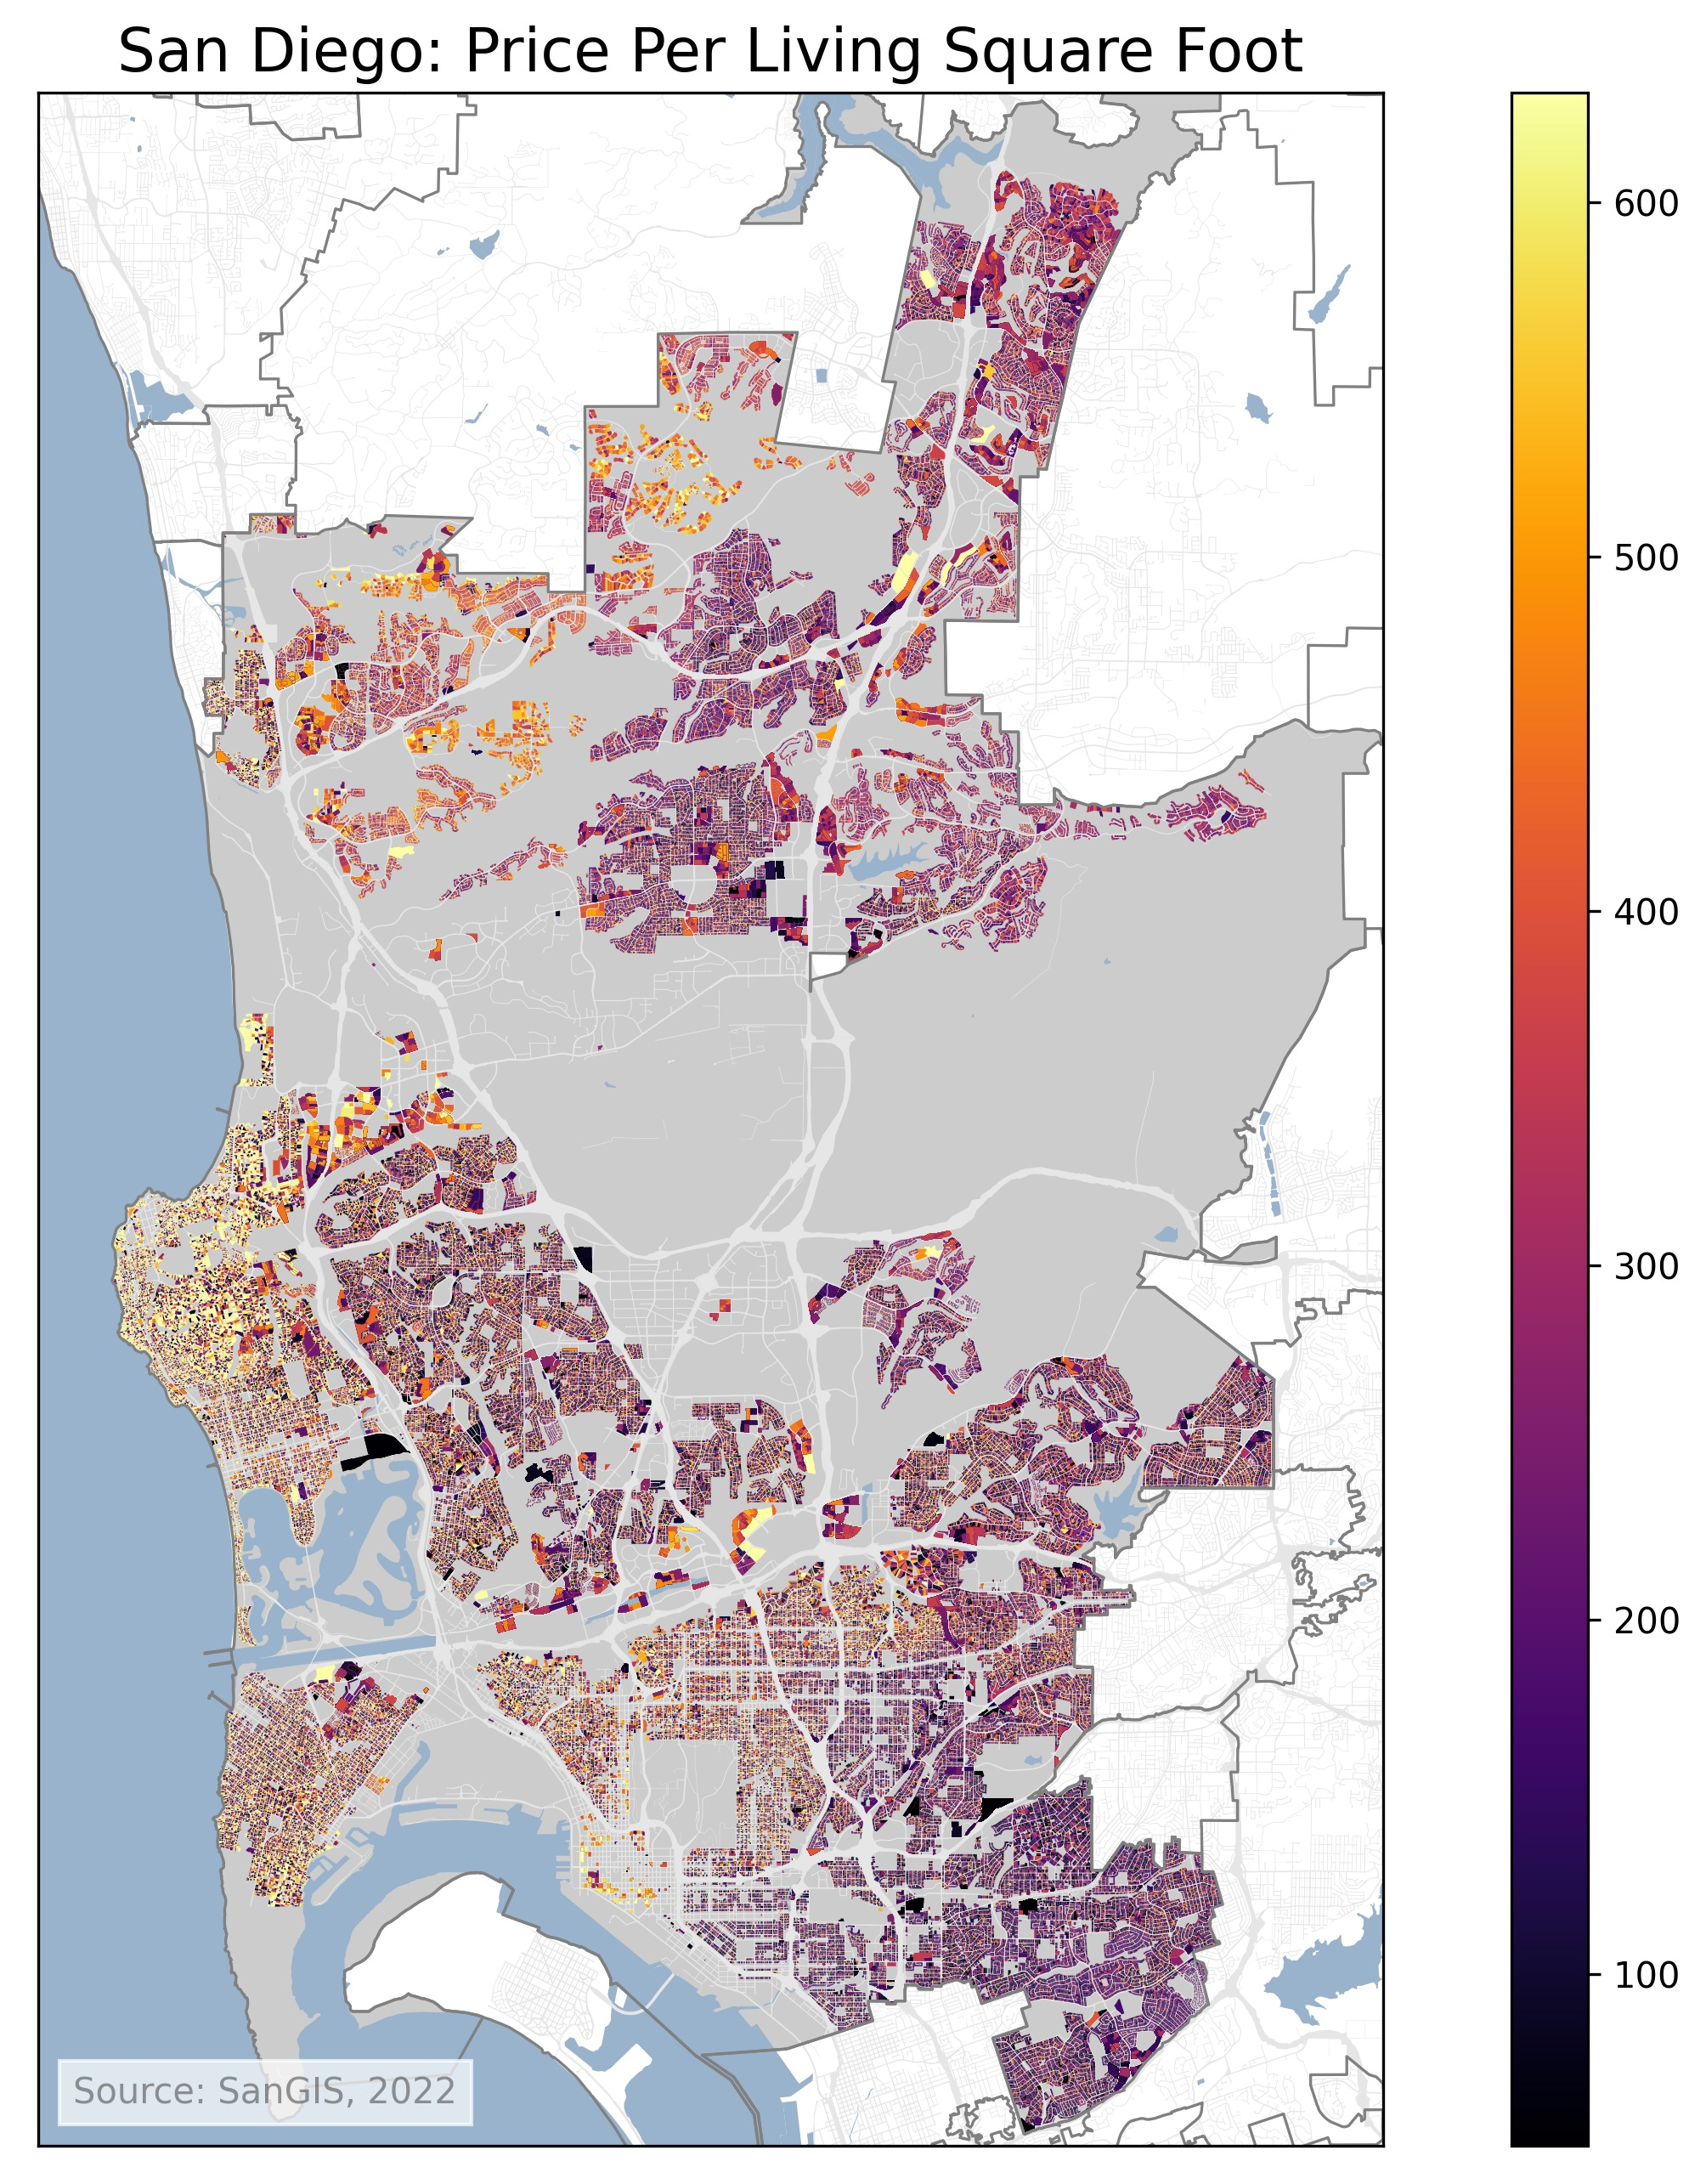

Skipping view renders/price_per_living_area_SM.jpg
Skipping view renders/price_per_living_area_SO.jpg
Skipping view renders/price_per_living_area_ST.jpg
Skipping view renders/price_per_living_area_VS.jpg


In [197]:
# Plot the parcel value per "total living area".  The denominator is found in the "TOTAL_LVG_" field inside
# parcels data, and is defined as follows:
#
#   The value includes square footage for both residential and commercial
#   structures but is incomplete. Values must be less than 99999 sq ft and may
#   not contain valid values where there are more than one structure on a parcel.
#   The value represents contiguous square footage of a structure.
#   Multiple structures are frequently added together to get a total square
#   footage, especially if they were built at the same time and are of the same
#   quality. The appraiser may leave the field blank if it would confuse data
#   analysis.

# zone code definitions are documented in Parcels.pdf
RESIDENTIAL_ZONE_CODES = [
    "10", # SINGLE FAMILY RESIDENTIAL
    "20", # MINOR MULTIPLE
    "21", # RESTRICTED MINOR MULTIPLE
    "30", # RESTRICTED MULTIPLE
    "31", # RESTRICTED RESTRICTED MULTIPLE
    "40", # MULTIPLE RESIDENTIAL
    "41", # RESTRICTED MULTIPLE RESIDENTIAL
]

def process_parcels_price_per_living_area(parcels=None):
    # Exclude everything that isn't residential.
    parcels = parcels[parcels["NUCLEUS_ZO"].isin(RESIDENTIAL_ZONE_CODES)]
    
    # Exclude weird parcels that don't have assessment values or total living space.
    parcels = parcels[
        (parcels["ASR_TOTAL"] > 0) &
        (parcels["TOTAL_LVG_"] > 0)
    ]

    # Calculate the metric we care about.
    parcels["ASR_VALUE_PER_LVG_AREA"] = parcels["ASR_TOTAL"] / parcels["TOTAL_LVG_"]
    
    return parcels

generate_maps(
    map_type_title="Price Per Living Square Foot",
    map_type_code="price_per_living_area",
    process_parcels=process_parcels_price_per_living_area,
    plot_column="ASR_VALUE_PER_LVG_AREA",
    get_vmin=lambda p: p["ASR_VALUE_PER_LVG_AREA"].quantile(0.05),
    get_vmax=lambda p: p["ASR_VALUE_PER_LVG_AREA"].quantile(0.95),
)